In [ ]:
import sys
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Add project src and utils directories to path
sys.path.append(str((Path().resolve() / '../src').resolve()))
sys.path.append(str((Path().resolve() / '../utils').resolve()))

from config import DATA_DIR, GROUP_MAP
from utils import read_csv, clean_deepfashion2
from data_loader import prepare_hierarchical_df

In [4]:
fashiondata_df = read_csv(DATA_DIR / "FashionData" / "styles.csv")
deepfashion2_df = read_csv(DATA_DIR / "DeepFashion2" / "img_info_dataframes" / "train.csv")
deepfashion2_df = clean_deepfashion2(deepfashion2_df)

print(fashiondata_df.head())
print(deepfashion2_df.head())

      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt  
                                                path  \
0  /kaggle/input/deepfashion2-original-with-dataf...   
1  /kaggle/input/

In [5]:
target_categories = list(GROUP_MAP.keys())

filtered_fashiondata_df = fashiondata_df[fashiondata_df['articleType'].isin(target_categories)]
filtered_fashiondata_df = fashiondata_df[
    (fashiondata_df['articleType'].isin(target_categories)) &
    (fashiondata_df['gender'].str.lower() == 'women')
]
filtered_deepfashion2_df = deepfashion2_df[deepfashion2_df['articleType'].isin(target_categories)][['id', 'articleType']].copy()

# balance DeepFashion2 by sampling up to 2000 images per category to reduce class imbalance.
balanced_deepfashion2_df = (
    filtered_deepfashion2_df
    .groupby('articleType')
    .apply(lambda x: x.sample(n=min(len(x), 2000), random_state=42))
    .reset_index(drop=True)
)

print(f"FashionData: {len(filtered_fashiondata_df)}")
print(f"DeepFashion2: {len(filtered_deepfashion2_df)}")
print(f"Balanced DeepFashion2: {len(balanced_deepfashion2_df)}")

filtered_fashiondata_df.head()

FashionData: 5493
DeepFashion2: 296091
Balanced DeepFashion2: 6000


/var/folders/ry/xs98p9sd6y3_rkdt0nrtqsb00000gn/T/ipykernel_32696/2932234331.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_deepfashion2_df


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
13,47957,Women,Accessories,Bags,Handbags,Blue,Summer,2012.0,Casual,Murcia Women Blue Handbag
19,47359,Women,Accessories,Bags,Handbags,Brown,Summer,2012.0,Casual,Baggit Women Brown Handbag
29,21977,Women,Accessories,Bags,Handbags,Brown,Winter,2015.0,Casual,Murcia Women Casual Brown Handbag
34,59051,Women,Footwear,Shoes,Flats,Black,Winter,2012.0,Casual,Carlton London Women Black & Gold Toned Flats
36,58183,Women,Accessories,Bags,Handbags,White,Summer,2012.0,Casual,Rocky S Women White Handbag


In [6]:
fashiondata_hierarchical_df = prepare_hierarchical_df(filtered_fashiondata_df, DATA_DIR / "FashionData" / "images", target_categories, GROUP_MAP)
deepfashion2_hierarchical_df = prepare_hierarchical_df(balanced_deepfashion2_df, DATA_DIR / "DeepFashion2" / "deepfashion2_original_images" / "train" / "image", target_categories, GROUP_MAP)

df_hierarchical = pd.concat([fashiondata_hierarchical_df, deepfashion2_hierarchical_df], ignore_index=True)
df_hierarchical.dropna(inplace=True)

print(df_hierarchical.groupby(["group", "articleType"]).size())

group     articleType 
Bags      Clutches         290
          Handbags        1689
          Wallets          465
Clothing  Dresses         2390
          Outerwear       2000
          Skirts          2104
Shoes     Casual Shoes     333
          Flats            500
          Heels           1322
          Sports Shoes     400
dtype: int64


In [7]:
# Save the hierarchical DataFrame to a CSV file
df_hierarchical.to_csv('../data/df_hierarchical.csv', index=False)

articleType
Dresses         2390
Skirts          2104
Outerwear       2000
Handbags        1689
Heels           1322
Flats            500
Wallets          465
Sports Shoes     400
Casual Shoes     333
Clutches         290
Name: count, dtype: int64


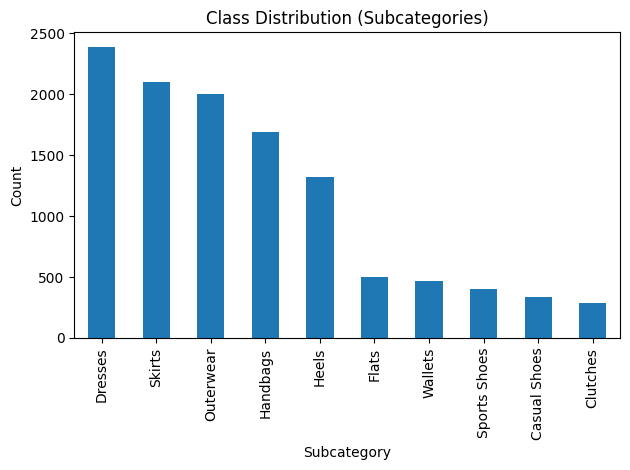

In [8]:
print(df_hierarchical['articleType'].value_counts())
df_hierarchical['articleType'].value_counts().plot(kind='bar')
plt.title('Class Distribution (Subcategories)')
plt.xlabel('Subcategory')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [11]:
print(df_hierarchical.isnull().sum())
missing_files = df_hierarchical[~df_hierarchical['image_path'].apply(os.path.exists)]
print(f"Missing files: {len(missing_files)}")

image_path     0
articleType    0
group          0
dtype: int64
Missing files: 0


In [12]:
print(df_hierarchical['articleType'].unique())
print(df_hierarchical['group'].unique())

['Handbags' 'Flats' 'Heels' 'Dresses' 'Skirts' 'Wallets' 'Clutches'
 'Casual Shoes' 'Sports Shoes' 'Outerwear']
['Bags' 'Shoes' 'Clothing']


In [13]:
class_counts = df_hierarchical['articleType'].value_counts(normalize=True) * 100
print(class_counts)

articleType
Dresses         20.795267
Skirts          18.306795
Outerwear       17.401897
Handbags        14.695902
Heels           11.502654
Flats            4.350474
Wallets          4.045941
Sports Shoes     3.480379
Casual Shoes     2.897416
Clutches         2.523275
Name: proportion, dtype: float64


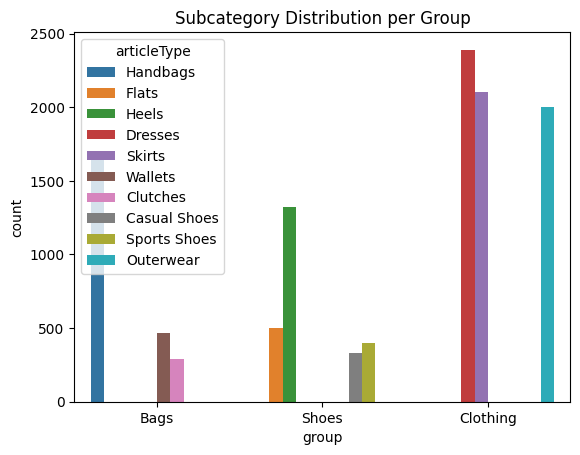

In [ ]:
sns.countplot(x='group', hue='articleType', data=df_hierarchical)
plt.title('Subcategory Distribution per Group')
plt.show()

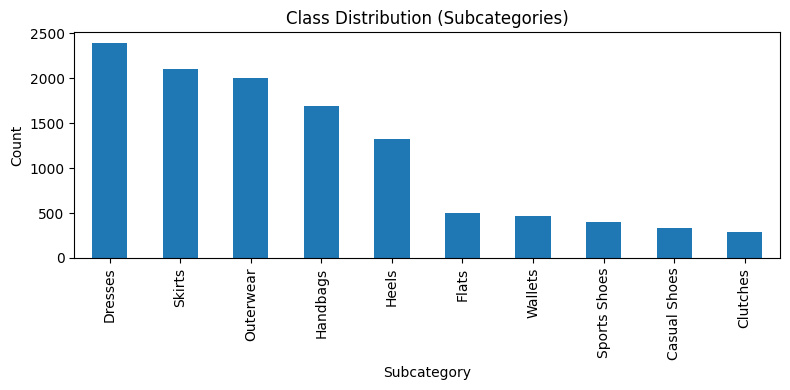

In [16]:
fig, ax = plt.subplots(figsize=(8,4))
df_hierarchical['articleType'].value_counts().plot(kind='bar', ax=ax)
plt.title('Class Distribution (Subcategories)')
plt.xlabel('Subcategory')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('../figures/category_distribution.png')